In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    precision_score, recall_score, f1_score,
    roc_curve, auc
)
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

RANDOM_STATE = 42
TARGET_COL = "color"

In [3]:
#1. load the data
df = pd.read_excel("wine_development.xlsx")

print("\nDevelopment shape:", df.shape)
print("Development columns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isna().sum())

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Columns: {df.columns.tolist()}")

# Drop identifier columns if present
drop_cols = [c for c in ["wine_id", "id", "ID"] if c in df.columns]

X = df.drop(columns=drop_cols + [TARGET_COL]).copy()
y = df[TARGET_COL].astype(str).str.strip().str.lower()

# Ensure numeric features only
non_numeric = [c for c in X.columns if not np.issubdtype(X[c].dtype, np.number)]
if non_numeric:
    raise ValueError(
        f"Non-numeric feature columns found: {non_numeric}\n"
        "Convert them to numeric or drop them."
    )


Development shape: (4157, 14)
Development columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color', 'wine_id']

Missing values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
wine_id                 0
dtype: int64


In [4]:
#2. null accuracy 

majority_class = y.value_counts().idxmax()
null_acc = (y == majority_class).mean()
print("\nClass counts:\n", y.value_counts())
print(f"\nNull accuracy (always predict '{majority_class}'): {null_acc:.4f}")


Class counts:
 color
white    3134
red      1023
Name: count, dtype: int64

Null accuracy (always predict 'white'): 0.7539


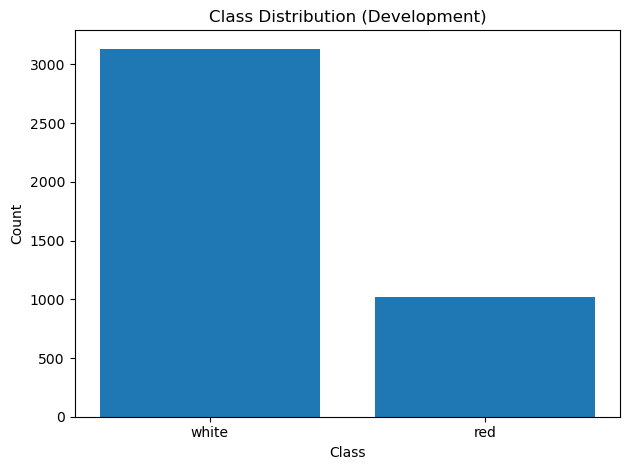

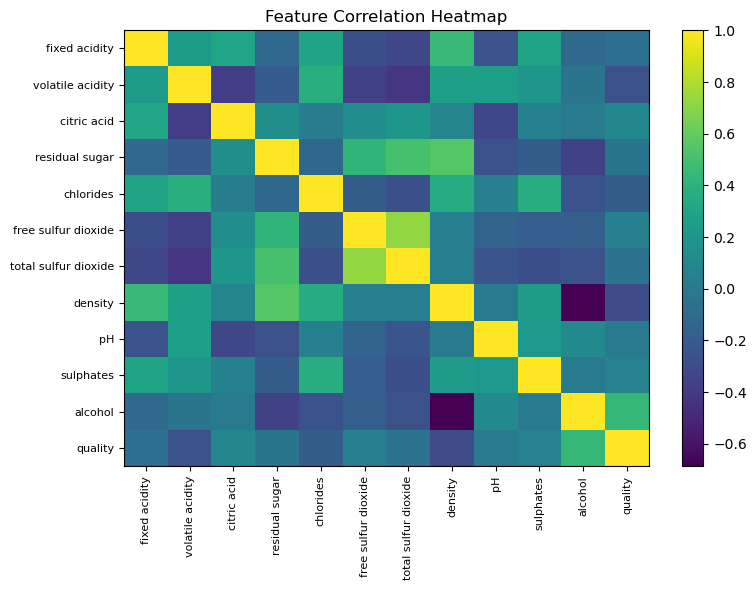


Top IQR-outlier counts (diagnostic only):
 citric acid             310
volatile acidity        239
fixed acidity           225
chlorides               181
quality                 151
sulphates               117
residual sugar           74
pH                       43
free sulfur dioxide      40
total sulfur dioxide      7
dtype: int64


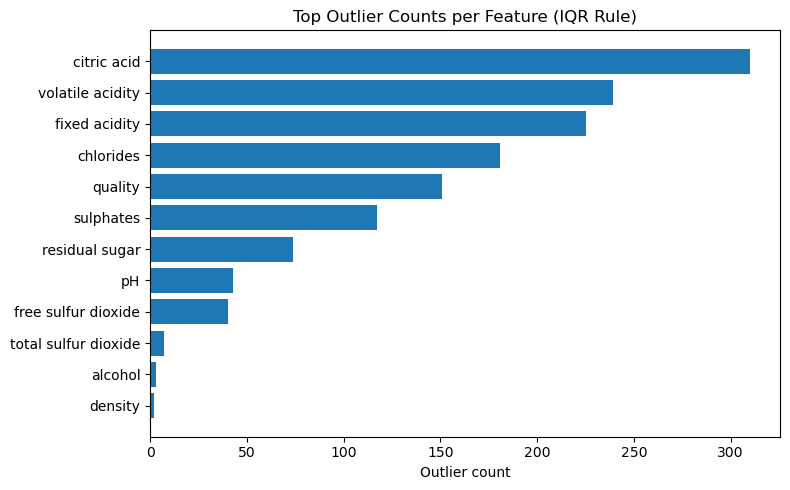

In [5]:
#3 DIAGRAM
# 3.1 Class distribution
plt.figure()
plt.bar(y.value_counts().index.tolist(), y.value_counts().values)
plt.title("Class Distribution (Development)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3.2 Correlation heatmap
corr = X.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
plt.imshow(corr.values, aspect="auto")
plt.title("Feature Correlation Heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=8)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8)
plt.colorbar()
plt.tight_layout()
plt.show()

# 3.3 Outlier diagnostic (IQR counts)
def iqr_outlier_count(s: pd.Series) -> int:
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return int(((s < lo) | (s > hi)).sum())

outlier_counts = X.apply(iqr_outlier_count).sort_values(ascending=False)
print("\nTop IQR-outlier counts (diagnostic only):\n", outlier_counts.head(10))

plt.figure(figsize=(8, 5))
top_out = outlier_counts.head(12)[::-1]
plt.barh(top_out.index, top_out.values)
plt.title("Top Outlier Counts per Feature (IQR Rule)")
plt.xlabel("Outlier count")
plt.tight_layout()
plt.show()

In [6]:
# 4) Train/test split (stratified)
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("\nTrain class distribution:\n", y_train.value_counts(normalize=True))
print("\nTest class distribution:\n", y_test.value_counts(normalize=True))


Train class distribution:
 color
white    0.753985
red      0.246015
Name: proportion, dtype: float64

Test class distribution:
 color
white    0.753606
red      0.246394
Name: proportion, dtype: float64


In [7]:
# 5) SVM Pipeline + Grid Search
# ============================================================
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

param_grid = [
    {"svc__kernel": ["linear"], "svc__C": [0.1, 1, 10, 100]},
    {"svc__kernel": ["rbf"], "svc__C": [0.1, 1, 10, 100], "svc__gamma": ["scale", 0.01, 0.1, 1]},
    {"svc__kernel": ["poly"], "svc__C": [0.1, 1, 10], "svc__gamma": ["scale", 0.01, 0.1], "svc__degree": [2, 3]},
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("\nBest params:", grid.best_params_)
print("Best CV score (f1_macro):", grid.best_score_)

Fitting 5 folds for each of 38 candidates, totalling 190 fits

Best params: {'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV score (f1_macro): 0.9939021729974664


In [8]:
# 6) Evaluation helper + plots
# ============================================================
def evaluate_and_plot(model, X_eval, y_eval, title_prefix="EVAL"):
    y_pred = model.predict(X_eval)

    acc = accuracy_score(y_eval, y_pred)
    prec = precision_score(y_eval, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_eval, y_pred, average="macro", zero_division=0)
    f1m = f1_score(y_eval, y_pred, average="macro", zero_division=0)

    print(f"\n=== {title_prefix} Metrics ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f} (macro)")
    print(f"Recall   : {rec:.4f} (macro)")
    print(f"F1-score : {f1m:.4f} (macro)")
    print("\nClassification Report:\n", classification_report(y_eval, y_pred, zero_division=0))

    labels = sorted(pd.Series(y_eval).unique())
    cm = confusion_matrix(y_eval, y_pred, labels=labels)
    print("Confusion Matrix (labels order =", labels, "):\n", cm)

    # Confusion matrix plot
    plt.figure()
    plt.imshow(cm, aspect="auto")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.xticks(range(len(labels)), labels)
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    # ROC (binary)
    if len(labels) == 2:
        pos_label = "red" if "red" in labels else labels[1]
        scores = model.decision_function(X_eval)
        y_bin = (pd.Series(y_eval).values == pos_label).astype(int)

        fpr, tpr, _ = roc_curve(y_bin, scores)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.title(f"{title_prefix} ROC (positive='{pos_label}')  AUC={roc_auc:.3f}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.tight_layout()
        plt.show()

    return y_pred



=== TEST Metrics ===
Accuracy : 0.9964
Precision: 0.9960 (macro)
Recall   : 0.9943 (macro)
F1-score : 0.9951 (macro)

Classification Report:
               precision    recall  f1-score   support

         red       1.00      0.99      0.99       205
       white       1.00      1.00      1.00       627

    accuracy                           1.00       832
   macro avg       1.00      0.99      1.00       832
weighted avg       1.00      1.00      1.00       832

Confusion Matrix (labels order = ['red', 'white'] ):
 [[203   2]
 [  1 626]]


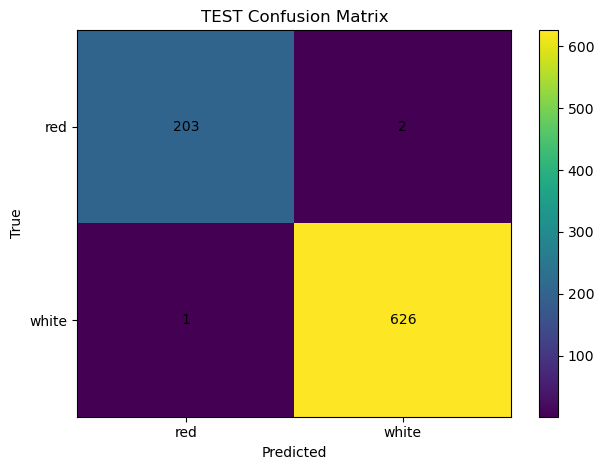

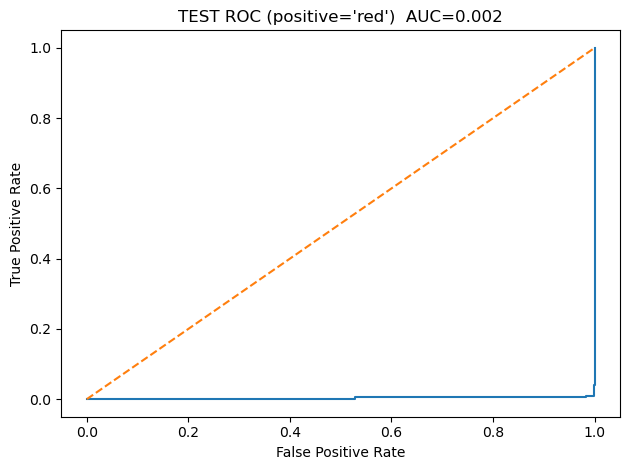


Null accuracy baseline: 0.7539


In [9]:
#7) TEST evaluation + diagrams
# ============================================================
y_test_pred = evaluate_and_plot(best_model, X_test, y_test, title_prefix="TEST")
print(f"\nNull accuracy baseline: {null_acc:.4f}")


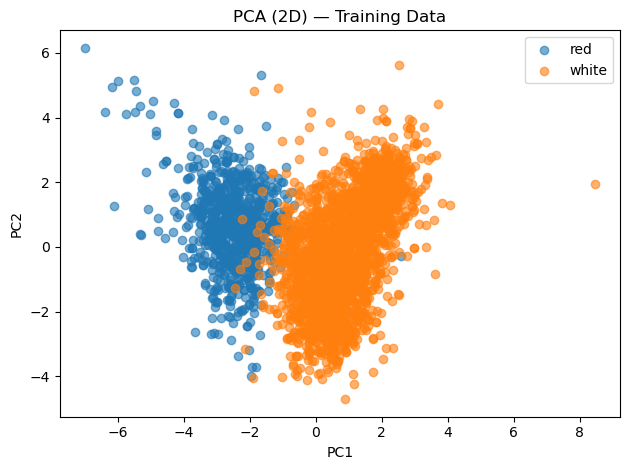

In [10]:
# 8) PCA diagram (fit on TRAIN only)
# ============================================================
scaler_for_pca = StandardScaler()
X_train_scaled = scaler_for_pca.fit_transform(X_train)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)

plt.figure()
for cls in sorted(y_train.unique()):
    mask = (y_train.values == cls)
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=cls, alpha=0.6)
plt.title("PCA (2D) — Training Data")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


Top permutation importances:
 density                 0.328227
residual sugar          0.137634
total sulfur dioxide    0.091954
alcohol                 0.088344
chlorides               0.011213
free sulfur dioxide     0.003780
volatile acidity        0.003406
citric acid             0.001785
sulphates               0.001713
fixed acidity           0.001612
dtype: float64


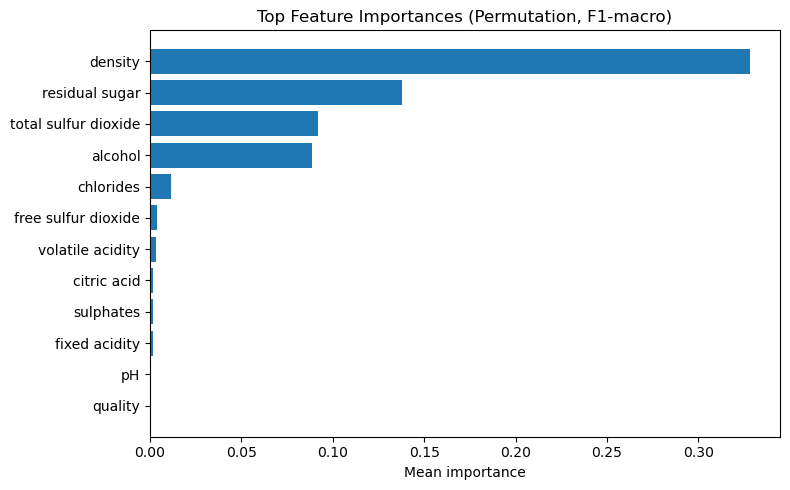

In [11]:
# 9) Permutation importance (TEST)
# ============================================================
perm = permutation_importance(
    best_model,
    X_test, y_test,
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="f1_macro"
)

importances = pd.Series(perm.importances_mean, index=X.columns).sort_values(ascending=False)
print("\nTop permutation importances:\n", importances.head(10))

plt.figure(figsize=(8, 5))
top_imp = importances.head(12)[::-1]
plt.barh(top_imp.index, top_imp.values)
plt.title("Top Feature Importances (Permutation, F1-macro)")
plt.xlabel("Mean importance")
plt.tight_layout()
plt.show()


=== HOLDOUT Metrics ===
Accuracy : 0.9933
Precision: 0.9929 (macro)
Recall   : 0.9890 (macro)
F1-score : 0.9909 (macro)

Classification Report:
               precision    recall  f1-score   support

         red       0.99      0.98      0.99       256
       white       0.99      1.00      1.00       784

    accuracy                           0.99      1040
   macro avg       0.99      0.99      0.99      1040
weighted avg       0.99      0.99      0.99      1040

Confusion Matrix (labels order = ['red', 'white'] ):
 [[251   5]
 [  2 782]]


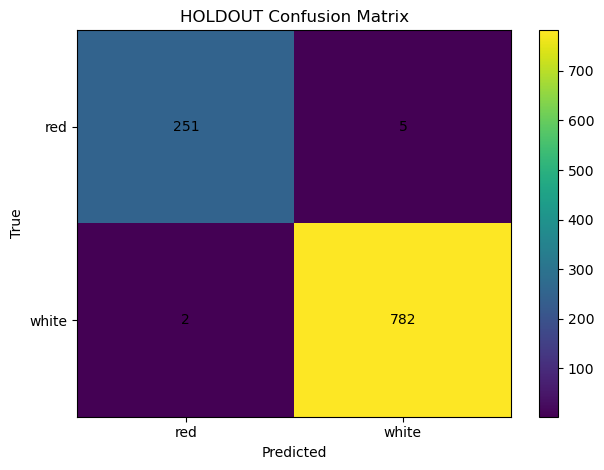

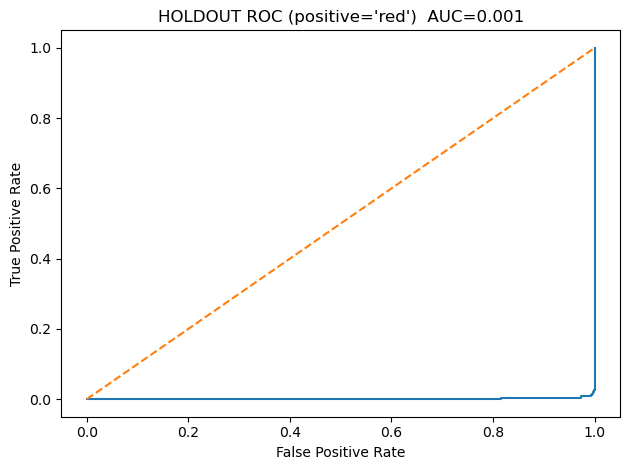


Saved predictions file: wine_holdout_predictions.csv


In [12]:
# 10) HOLDOUT evaluation (X + y) + diagrams
# ============================================================
holdout_X = pd.read_excel("wine_holdout_x.xlsx")
holdout_y_df = pd.read_excel("wine_holdout_y.xlsx")

# holdout_y: take the first column if it's a one-column sheet
if holdout_y_df.shape[1] == 1:
    holdout_y = holdout_y_df.iloc[:, 0]
elif TARGET_COL in holdout_y_df.columns:
    holdout_y = holdout_y_df[TARGET_COL]
else:
    holdout_y = holdout_y_df.iloc[:, 0]

holdout_y = holdout_y.astype(str).str.strip().str.lower()

# Drop id cols if present (must match training)
for c in drop_cols:
    if c in holdout_X.columns:
        holdout_X = holdout_X.drop(columns=[c])

# Align columns to training
missing = [c for c in X.columns if c not in holdout_X.columns]
extra = [c for c in holdout_X.columns if c not in X.columns]

if missing:
    raise ValueError(f"Holdout is missing feature columns: {missing}")
if extra:
    holdout_X = holdout_X.drop(columns=extra)

holdout_X = holdout_X[X.columns]  # enforce same order

holdout_pred = evaluate_and_plot(best_model, holdout_X, holdout_y, title_prefix="HOLDOUT")

# Save predictions
pd.Series(holdout_pred, name="pred_color").to_csv("wine_holdout_predictions.csv", index=False)
print("\nSaved predictions file: wine_holdout_predictions.csv")


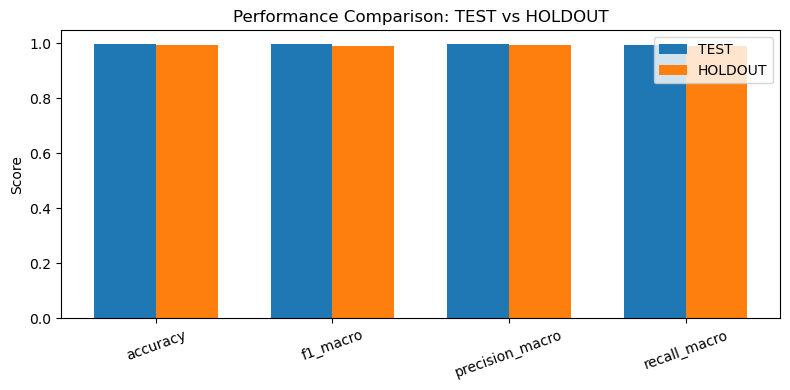

In [13]:
# 11) Diagram: Compare TEST vs HOLDOUT metrics
# ============================================================
def metric_bundle(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
    }

test_metrics = metric_bundle(y_test, y_test_pred)
hold_metrics = metric_bundle(holdout_y, holdout_pred)

names = list(test_metrics.keys())
test_vals = [test_metrics[k] for k in names]
hold_vals = [hold_metrics[k] for k in names]

x = np.arange(len(names))
w = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - w/2, test_vals, width=w, label="TEST")
plt.bar(x + w/2, hold_vals, width=w, label="HOLDOUT")
plt.xticks(x, names, rotation=20)
plt.title("Performance Comparison: TEST vs HOLDOUT")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()